In [1]:
import pyro
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import pyro.distributions as dist
from sklearn.cluster import KMeans
from pyro.distributions import constraints
from ffjord.lib.toy_data import inf_train_gen
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
pyro.enable_validation(True)

In [2]:
class GaussianMixtureModel(PyroModule):
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.M = None
        self.locs = None
        self.scales = None
        self.initialized = False
        self.fitted = False
        self.weights = PyroParam(torch.ones(K) / K,
                                 constraint=constraints.simplex)
        self.losses = list()
        self.eval()
    
    
    def random_init(self, M):
        self.M = M
        self.locs = PyroParam(torch.rand(self.K, self.M),
                              constraint=constraints.real)
        self.scales = PyroParam(torch.rand(self.K, self.M),
                                constraint=constraints.positive)
        self.initialized = True
    
    
    def constant_init(self, M, loc=0., scale=1.):
        self.M = M
        self.locs = PyroParam(torch.ones(self.K, self.M)*loc,
                             constraint=constraints.real)
        self.scales = PyroParam(torch.ones(self.K, self.M)*scale,
                             constraint=constraints.real)
        self.initialized = True
    
    
    def init_from_data(self, data, k_means=False):
        N, M = data.shape[0], data.shape[1]
        self.M = M
        self.locs = PyroParam(data[torch.multinomial(torch.ones(N) / N, self.K),],
                              constraint=constraints.real)
        self.scales = PyroParam(data.std(dim=0).repeat(self.K).reshape(self.K, self.M),
                                constraint=constraints.positive)
        
        if k_means:
            data = data.numpy()
            k_means_model = KMeans(self.K)
            k_means_model.fit(data)
            locs = k_means_model.cluster_centers_
            self.locs = PyroParam(torch.tensor(locs),
                              constraint=constraints.real)
            
        self.initialized = True
    
    @config_enumerate
    def forward(self, data=None):
        shape = data.shape if data is not None else (1000, 2)
        N, M = shape[0], shape[1]
        
        if self.initialized is False and data is not None:
            self.init_from_data(data)
            self.initialized = True
        elif self.initialized is False:
            self.random_init(M)
            self.initalized = True
        
        if M != self.M:
            raise ValueError('Incorrect number of data columns.')
        
        x_obs = torch.zeros(N, M)
        with pyro.plate('data', N):
            k = pyro.sample('k', dist.Categorical(self.weights))
            
            locs = self.weights[k]
            scales = self.scales[k]
            
            for m in range(self.M):
                obs = data[:,m] if data is not None else None
                x_obs[:,m] = pyro.sample('x_{}'.format(m),
                                         dist.Normal(loc=self.locs[k, m],
                                                     scale=self.scales[k, m]),
                                        obs=obs)
            return x_obs
        
    
    def guide(self, data):
        pass
    
    
    def fit_model(self, data, lr=3e-4, n_steps=10000):
        self.train()
        
        N = len(data)
        adam = pyro.optim.Adam({"lr": lr})
        svi = SVI(self, self.guide, adam, loss=TraceEnum_ELBO())
        
        for step in range(n_steps):
            loss = svi.step(data)
            self.losses.append(loss / N)
            
            if step % 1000 == 0:
                print('[iter {}]  loss: {:.4f}'.format(step, loss))
        
        self.fitted = True
        self.eval()
    
    def density(self, data):
        with torch.no_grad():
            N, M = data.shape[0], data.shape[1]
            if M != self.M:
                raise ValueError('Incorrect number of data columns.')
        
            temp = dist.Normal(
                loc=self.locs.reshape(self.K, -1, self.M).repeat(1, N, 1),
                scale=self.scales.reshape(self.K, -1, self.M).repeat(1, N,1)).log_prob(data)
            temp = torch.exp(torch.sum(temp, dim=2))
            density = torch.sum(temp, dim=0)
        
        return density
        
    
    def log_likelihood(self, data):
        with torch.no_grad():
            llh = torch.sum(torch.log(self.density(data)))
        return llh
    
    
    def eval_density_grid(self, n_points=100):
        if self.M != 2:
            raise ValueError('Can only evaluate density grid for 2-dimensional data.')
        x_grid = np.linspace(-5, 5, n_points)
        X1, X2 = np.meshgrid(x_grid, x_grid)
        XX = np.column_stack((X1.ravel(), X2.ravel()))
        densities = self.density(torch.tensor(XX)).numpy()
        
        return x_grid, densities.reshape((n_points, n_points))
        
        

In [3]:
data = torch.from_numpy(inf_train_gen('8gaussians', batch_size=10000))

In [4]:
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data, k_means=True)
model.fit_model(data, n_steps=8000)

[iter 0]  loss: 44282.2266
[iter 1000]  loss: 41448.2617
[iter 2000]  loss: 38986.9219
[iter 3000]  loss: 35935.5039
[iter 4000]  loss: 31615.6406
[iter 5000]  loss: 29157.0918
[iter 6000]  loss: 28461.0645
[iter 7000]  loss: 28393.4785


In [6]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data))

Log likelihood of data: tensor(-7600.1641)


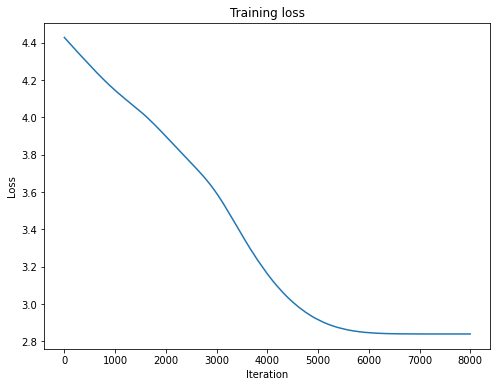

In [7]:
# Plot of training loss
fig = plt.figure(figsize=(8,6))
plt.plot(model.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show();

In [8]:
# Evaluate density
x_grid, density_eval = model.eval_density_grid()

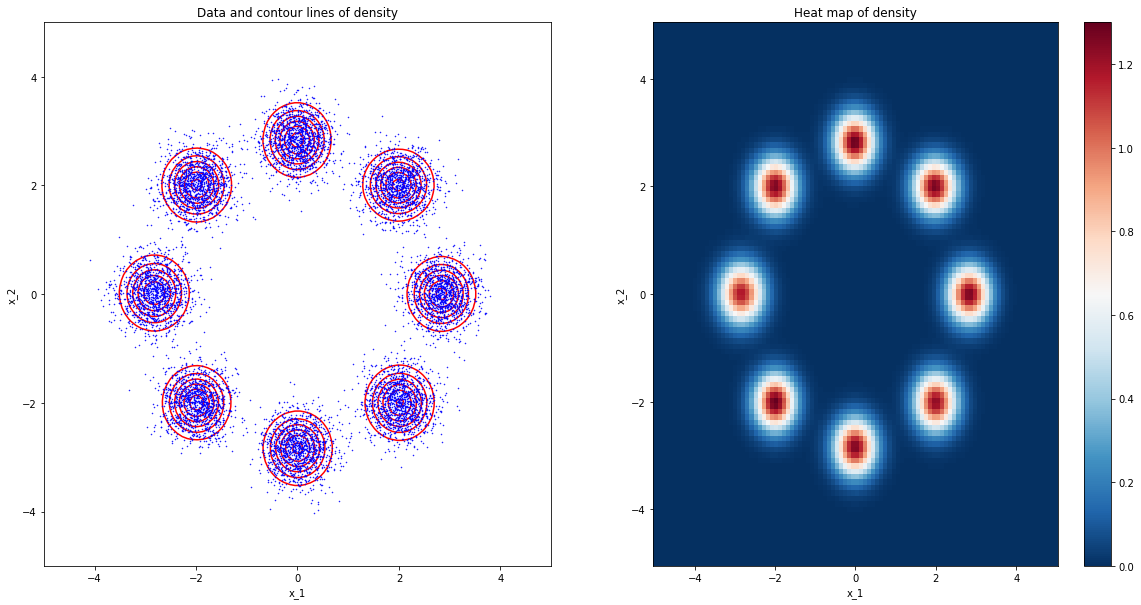

In [9]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,
                                    figsize=(20, 10))
# Plot of data and contour lines of density
ax1.plot(data[:,0], data[:,1], 'b.', markersize=1)
ax1.contour(x_grid, x_grid, density_eval, colors='red')
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Data and contour lines of density')

# Color map of density
cm = ax2.pcolormesh(x_grid, x_grid, density_eval, cmap=plt.cm.RdBu_r, shading='auto')
cbar = fig.colorbar(cm)
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Heat map of density')
plt.show();

In [10]:
data = torch.tensor(inf_train_gen('checkerboard', batch_size=10000), dtype=torch.float)

In [11]:
# Fit model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data, k_means=True)
model.fit_model(data, n_steps=6000)

[iter 0]  loss: 46826.3164
[iter 1000]  loss: 44666.7227
[iter 2000]  loss: 43088.6641
[iter 3000]  loss: 40939.0664
[iter 4000]  loss: 38538.7109
[iter 5000]  loss: 38058.0781


In [12]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data))

Log likelihood of data: tensor(-17247.5039)


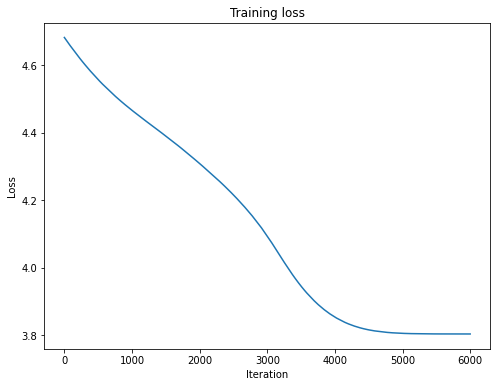

In [13]:
# Plot loss
fig = plt.figure(figsize=(8,6))
plt.plot(model.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show();

In [14]:
# Evaluate density
x_grid, density_eval = model.eval_density_grid()

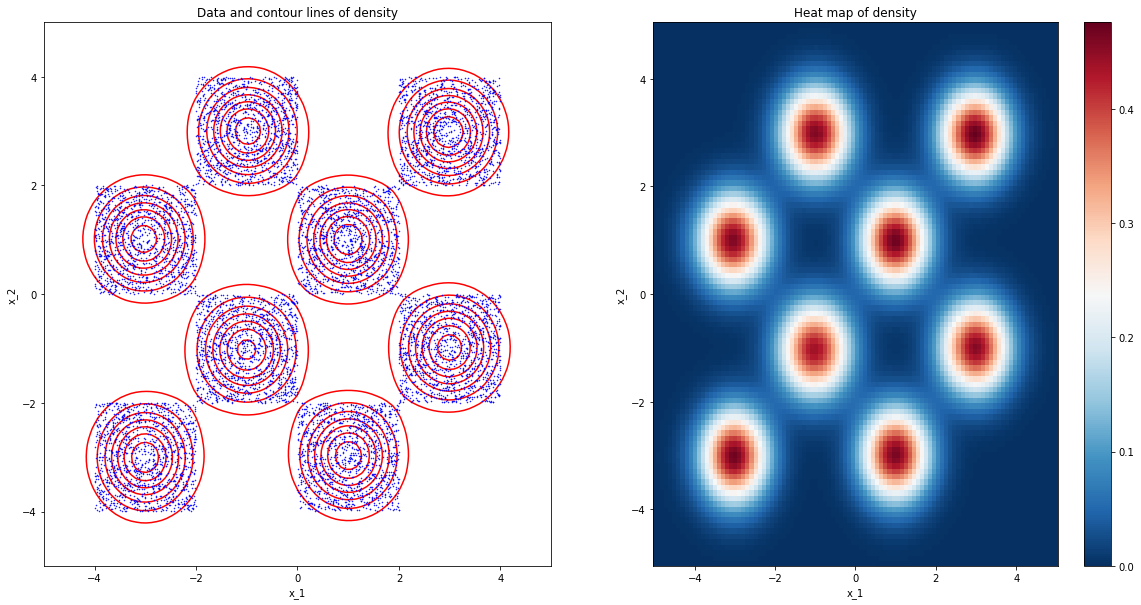

In [15]:
# Plot density
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,
                                    figsize=(20, 10))
# Plot of data and contour lines of density
ax1.plot(data[:,0], data[:,1], 'b.', markersize=1)
ax1.contour(x_grid, x_grid, density_eval, colors='red')
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Data and contour lines of density')

# Color map of density
cm = ax2.pcolormesh(x_grid, x_grid, density_eval, cmap=plt.cm.RdBu_r, shading='auto')
cbar = fig.colorbar(cm)
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Heat map of density')
plt.show();